#### DATA ANALYSIS / EXPLORATION FOR THE CLAIMS (2015 to 2019) AND MEMBER ENROLL DATA

In [276]:
import os
import sys
import time
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
import logging
import yaml
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
warnings.simplefilter("ignore")

#### LOADING ALL THE CLAIMS FOR 2015,2016,2017,2018 and 2019

In [142]:
# Loading the claims data files

input_years = [2015,2016,2017,2018,2019]

CLAIM_PATH = Path("inputFiles/claims/")
df_claims = pd.concat(
    [pd.read_csv(CLAIM_PATH / Path(f"claims_{year}.dat"),dtype='unicode',sep = "|") for year in input_years]
)

#### TOTAL CLAIM DATA FOR ALL YEARS

In [144]:
df_claims["pat_id"].count()

2438054

In [145]:
df_claims['from_dt']=pd.to_datetime(df_claims['from_dt'], format='%Y-%m-%d')
df_claims['claim_year']=pd.DatetimeIndex(df_claims['from_dt']).year

In [146]:
er_rev_codes = ["0450","0451","0452","0453","0454","0455","0456","0457","0458","0459","0981"]
df_claims["ER_Ind"] = np.where(df_claims.rev_code.isin(er_rev_codes),"Y","N")

#### CLAIM COUNT BY YEAR

In [147]:
claims_df_year = df_claims[["pat_id","claim_year"]].groupby(['claim_year'])
claims_df_year["pat_id"].count()

claim_year
2015    736051
2016    842013
2017    467478
2018    232699
2019    159813
Name: pat_id, dtype: int64

#### ER VISIT CLAIM COUNT BY YEAR

In [340]:
df_claims = df_claims[df_claims.rectype != "P"]
df_claims = df_claims[df_claims.rectype != ""]
counts = df_claims[["pat_id","claim_year","ER_Ind"]].groupby(['claim_year','ER_Ind']).count()
counts = counts.unstack(level=1)
counts.columns = counts.columns.droplevel(level=0)
print(counts)

claim_years = df_claims.claim_year.unique()

ER_Ind           N      Y
claim_year               
2015        513274   9808
2016        577410  11245
2017        323433   5542
2018        168959   2318
2019        116874   1830


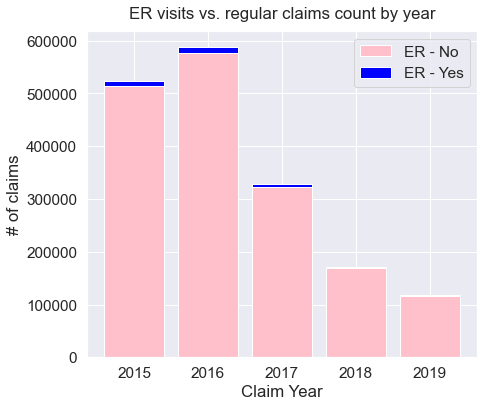

In [353]:
sns.set(font_scale=1.4)
fig = plt.figure(figsize = (7, 6))

plt.bar(claim_years, counts['N'], bottom=None, color='pink', label='ER - No')
plt.bar(claim_years, counts['Y'], bottom=counts['N'], color='blue', label='ER - Yes')

plt.legend()
plt.xlabel('Claim Year')
plt.ylabel('# of claims')
plt.title("ER visits vs. regular claims count by year", y=1.02)
plt.show()

#### PERCENTAGE OF PATIENTS WITH MORE THAN 100 CLAIMS IN TOTAL

In [139]:
claims_df_year = df_claims.groupby("pat_id")
clm_cnt = claims_df_year["pat_id"].count()
clm_cnt = pd.Series.to_frame(clm_cnt)
clm_cnt = clm_cnt.rename(columns = {"pat_id":'count'})
clm_cnt = clm_cnt[clm_cnt["count"] >= 100]
total_claims = df_claims["pat_id"].count()
patient_clm_cnt = clm_cnt.count()
print("Total percentage of patients with more than 100 claims ",(patient_clm_cnt/total_claims) * 100)

Total percentage of patients with more than 100 claims  count    0.298394
dtype: float64


#### PERCENTAGE OF PATIENTS WITH ER VISITS MORE THAN 100 CLAIMS

In [140]:
claims_df_year = df_claims[df_claims.ER_Ind == "Y"].groupby("pat_id")
clm_cnt = claims_df_year["pat_id"].count()
clm_cnt = pd.Series.to_frame(clm_cnt)
clm_cnt = clm_cnt.rename(columns = {"pat_id":'count'})
clm_cnt = clm_cnt[clm_cnt["count"] >= 100]
total_claims = df_claims["pat_id"].count()
patient_clm_cnt = clm_cnt.count()
print("Total percentage of ER visit patients with more than 100 claims ",(patient_clm_cnt/total_claims) * 100)

Total percentage of ER visit patients with more than 100 claims  count    0.000164
dtype: float64


% of patients with more than 100 claims sequence is only 0.3% and also the % of patients who went to ER visits and have more than 100 claims sequence is only 0.000164% the above data suggests that looking for claims sequence with 100 claims sequence over a period of time is sufficient

#### PERCENTAGE OF PATIENTS WITH JUST ONE CLAIM IN TOTAL

In [80]:
claims_df_year = df_claims.groupby("pat_id")
clm_cnt = claims_df_year["pat_id"].count()
clm_cnt = pd.Series.to_frame(clm_cnt)
clm_cnt = clm_cnt.rename(columns = {"pat_id":'count'})
clm_cnt = clm_cnt[clm_cnt["count"] == 1]
total_claims = df_claims["pat_id"].count()
patient_clm_cnt = clm_cnt.count()
print("Total percentage of patients with just one claims ",(patient_clm_cnt/total_claims) * 100)

Total percentage of patients with just one claims  count    0.017842
dtype: float64


% of patients with just 1 claim in total is only 0.017. The claim records of these patients doesn't add value to the model so in the data preprocessing step these records will get deleted

#### TOTAL PHARMACY CLAIMS IN THE DATASET

In [77]:
total_claims = df_claims["pat_id"].count()
pharmacy_claims = df_claims[df_claims.rectype == "P"]["pat_id"].count()
(pharmacy_claims/total_claims) * 100

29.013344249142964

Almost 30% of the dataset belongs to pharmacy claims which doesn't have diag codes associated but only ND

#### CLAIMS WITH NULL RECORD TYPE

In [78]:
total_claims = df_claims["pat_id"].count()
df_claims = df_claims.fillna('')
null_rectype_claims = df_claims[df_claims.rectype == ""]["pat_id"].count()
(null_rectype_claims/total_claims) * 100

1.6418832396657332

#### CCS (CLINICAL CLASSIFICATION SOFTWARE) LABELLING FOR ICD9 AND ICD10 DIAGNOSIS CODES
https://www.hcup-us.ahrq.gov/toolssoftware/ccsr/DXCCSR-Reference-File-v2020-2.xlsx

In [85]:
CCS_PATH = Path("inputFiles/CCS/")

df_ccs_xwlk = pd.read_csv (CCS_PATH / Path("ccs_xwlk.csv"),dtype='unicode') 

ccs_dict = {row.proc_cd:row.CCSR_label for index,row in df_ccs_xwlk.iterrows()}

print("TOTAL PROCEDURE CODES - CCS LABELS ",len(ccs_dict))

TOTAL PROCEDURE CODES - CCS LABELS  72715


#### FLITERING CLAIMS FOR PHARMACY AND NULL RECORD TYPES

In [84]:
df_claims = df_claims[df_claims.rectype != "P"]
df_claims = df_claims[df_claims.rectype != ""]
df_claims["pat_id"].count()

1690663

#### IDENTIFYING THE TOP DISEASES CONTRIBUTING TO THE ER VISITS

In [178]:
df_claims_er = df_claims[df_claims.ER_Ind == "Y"]

In [93]:
df_claims_er = df_claims_er.reset_index()

In [95]:
df_claims_er = df_claims_er.astype('object')
df_claims_er["diagSeq"] = ""

In [96]:
cnt = 0

for index,row in df_claims_er.iterrows():
    seq = []

    # For all 12 diagnosis codes in the claims file

    if len(row["diag1"].strip()) > 0 and row["diag1"] in ccs_dict:
        seq.append(int(ccs_dict[row["diag1"]]))
            
    if len(row["diag2"].strip()) > 0 and row["diag2"] in ccs_dict:
        seq.append(int(ccs_dict[row["diag2"]]))           
            
    if len(row["diag3"].strip()) > 0 and row["diag3"] in ccs_dict:
        seq.append(int(ccs_dict[row["diag3"]]))

    if len(row["diag4"].strip()) > 0 and row["diag4"] in ccs_dict:
        seq.append(int(ccs_dict[row["diag4"]]))

    if len(row["diag5"].strip()) > 0 and row["diag5"] in ccs_dict:
        seq.append(int(ccs_dict[row["diag5"]]))        

    if len(row["diag6"].strip()) > 0 and row["diag6"] in ccs_dict:
        seq.append(int(ccs_dict[row["diag6"]]))
    
    if len(row["diag7"].strip()) > 0 and row["diag7"] in ccs_dict:
        seq.append(int(ccs_dict[row["diag7"]]))
            
    if len(row["diag8"].strip()) > 0 and row["diag8"] in ccs_dict:
        seq.append(int(ccs_dict[row["diag8"]]))
            
    if len(row["diag9"].strip()) > 0 and row["diag9"] in ccs_dict:
        seq.append(int(ccs_dict[row["diag9"]]))
            
    if len(row["diag10"].strip()) > 0 and row["diag10"] in ccs_dict:
        seq.append(int(ccs_dict[row["diag10"]]))
                    
    if len(row["diag11"].strip()) > 0 and row["diag11"] in ccs_dict:
        seq.append(int(ccs_dict[row["diag11"]]))
            
    if len(row["diag12"].strip()) > 0 and row["diag12"] in ccs_dict:
        seq.append(int(ccs_dict[row["diag12"]]))

    if len(seq) > 0:
        df_claims_er.loc[index, 'diagSeq'] = sorted(seq)
        cnt += 1    

In [99]:
df_claims_er = df_claims_er[df_claims_er.diagSeq != ""]

In [101]:
ccs_label_list = [i for i in range(1,540)]

In [105]:
er_visit_cnt = {}

for i in range(len(ccs_label_list)):
    
    er_visit_cnt[ccs_label_list[i]] = 0
    for index,row in df_claims_er.iterrows():
        if ccs_label_list[i] in row.diagSeq:
            er_visit_cnt[ccs_label_list[i]] += 1

In [107]:
file_to_write = open("output/er_visit_cnt.pickle", "wb")
pickle.dump(er_visit_cnt, file_to_write)

In [112]:
CCS_DESC_PATH = Path("inputFiles/CCS/")

df_ccs_desc = pd.read_csv (CCS_DESC_PATH / Path("ccs_desc.csv"),dtype='unicode')

ccs_desc_dict = {}

for index,row in df_ccs_desc.iterrows():
    ccs_desc_dict[int(row.CCS_Code)] = row.CCS_Desc

In [296]:
df_ccs = pd.DataFrame(columns = ['Disease', 'ER Count'])

for key in er_visit_cnt.keys():
    df_ccs = df_ccs.append({'Disease' : ccs_desc_dict[key], 'ER Count' : er_visit_cnt[key]},
                           ignore_index = True)

In [297]:
df_ccs = df_ccs.sort_values(by=['ER Count'],ascending=False).head(10)

In [298]:
df_ccs['Disease'] = df_ccs['Disease'].str[:25]

#### TOP 10 DISEASES CAUSING ER VISITS BASED ON DIAGNOSIS CODES IN THE CLAIM

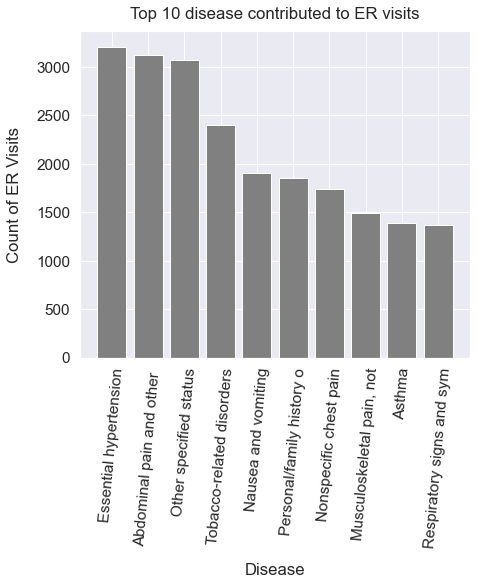

In [306]:
sns.set(font_scale=1.4)
fig = plt.figure(figsize = (7, 6))
plt.bar(df_ccs["Disease"],df_ccs["ER Count"], color = "gray")
plt.xticks(rotation=85)

plt.xlabel("Disease", labelpad=14)
plt.ylabel("Count of ER Visits", labelpad=14)
plt.title("Top 10 disease contributed to ER visits", y=1.02)
plt.show()

#### DATA ANALYSIS ON THE MEMBER DEMOGRAPHICS DATA

In [233]:
ENROLL_PATH = Path("inputFiles/enroll/")
df_enroll = pd.read_csv(ENROLL_PATH / Path("enroll_synth.dat"),dtype='unicode',sep = "|")

In [234]:
df_enroll = df_enroll[~df_enroll.der_yob.isin(["0",np.nan])]
df_enroll["der_yob"] = df_enroll["der_yob"].astype(int)

In [235]:
df_enroll = df_enroll.reindex()

#### CALCULATE AGE AS OF 2019 (FOR HIGHEST CLAIM YEAR DATA)

In [236]:
df_enroll["age"] = 2019 - df_enroll["der_yob"]

#### GET UNIQUE LIST OF PATIENT IDS WITH EMERGENCY CLAIM VISITS

In [237]:
er_pat_list = df_claims_er["pat_id"].unique()

In [243]:
er_pat_dict = {er_pat_list[i]:1 for i in range(len(er_pat_list))}

In [245]:
df_enroll["ER_Ind"] = "N"

In [246]:
for index,row in df_enroll.iterrows():
    if row.pat_id in er_pat_dict:
        df_enroll.loc[index, 'ER_Ind'] = "Y"

#### TOTAL PATIENTS WITH ATLEAST ONE EMERGENCY CLAIMS

In [249]:
df_enroll[df_enroll.ER_Ind == "Y"]["pat_id"].count()

8567

In [251]:
df_enroll["age"] = np.where(df_enroll.age == 2019,0,df_enroll.age)

In [253]:
df_enroll["age"].min(),df_enroll["age"].max()

(0, 85)

In [259]:
df_enroll["age_catg"] = ""

In [260]:
df_enroll["age_catg"] = np.where( (df_enroll.age >= 0) & (df_enroll.age <= 20),"0-20",df_enroll.age_catg)
df_enroll["age_catg"] = np.where( (df_enroll.age >= 21) & (df_enroll.age <= 40),"21-40",df_enroll.age_catg)
df_enroll["age_catg"] = np.where( (df_enroll.age >= 41) & (df_enroll.age <= 60),"41-60",df_enroll.age_catg)
df_enroll["age_catg"] = np.where( (df_enroll.age >= 61) & (df_enroll.age <= 80),"61-80",df_enroll.age_catg)
df_enroll["age_catg"] = np.where( (df_enroll.age >= 81) & (df_enroll.age <= 100),"81-100",df_enroll.age_catg)

### VISUALIZATION OF THE DATA FOR AGE GROUP

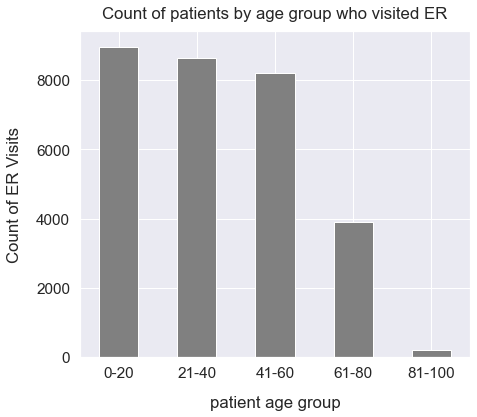

In [307]:
sns.set(font_scale=1.4)
df_enroll["age_catg"].value_counts().plot(kind='bar', figsize=(7, 6), rot=0,color = "gray")
plt.xlabel("patient age group", labelpad=14)
plt.ylabel("Count of ER Visits", labelpad=14)
plt.title("Count of patients by age group who visited ER", y=1.02)
plt.show()

In [272]:
df_enroll["Gender"] = ""

In [273]:
df_enroll["Gender"] = np.where(df_enroll.der_sex == "M","Male",df_enroll.Gender)
df_enroll["Gender"] = np.where(df_enroll.der_sex == "F","Female",df_enroll.Gender)
df_enroll["Gender"] = np.where( (df_enroll.der_sex != "F") & (df_enroll.der_sex != "M"),"Unknown",df_enroll.Gender)

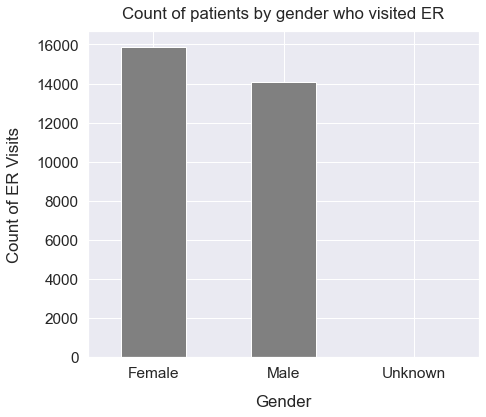

In [308]:
sns.set(font_scale=1.4)
df_enroll["Gender"].value_counts().plot(kind='bar', figsize=(7, 6), rot=0,color = "gray")
plt.xlabel("Gender", labelpad=14)
plt.ylabel("Count of ER Visits", labelpad=14)
plt.title("Count of patients by gender who visited ER", y=1.02)
plt.show()